# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[128, 64, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="elu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="elu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-3]
EPOCHS = 100
BATCH_SIZE = 256
MOMENTUM = 0.95



In [7]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-lr-%s" % (str(lr))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.001000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 406,410
Trainable params: 406,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]

50000/50000 [==============================] - 1s 16us/step - loss: 1.1526 - acc: 0.5928 - val_loss: 1.4119 - val_acc: 0.5043
Epoch 53/100
50000/50000 [==============================] - 1s 18us/step - loss: 1.1472 - acc: 0.5950 - val_loss: 1.3633 - val_acc: 0.5237
Epoch 54/100
50000/50000 [==============================] - 1s 16us/step - loss: 1.1416 - acc: 0.5981 - val_loss: 1.3632 - val_acc: 0.5240
Epoch 55/100
50000/50000 [==============================] - 1s 17us/step - loss: 1.1384 - acc: 0.5979 - val_loss: 1.3637 - val_acc: 0.5235
Epoch 56/100
50000/50000 [==============================] - 1s 17us/step - loss: 1.1311 - acc: 0.6012 - val_loss: 1.3562 - val_acc: 0.5235
Epoch 57/100
50000/50000 [==============================] - 1s 16us/step - loss: 1.1242 - acc: 0.6036 - val_loss: 1.3782 - val_acc: 0.5159
Epoch 58/100
50000/50000 [==============================] - 1s 16us/step - loss: 1.1206 - acc: 0.6027 - val_loss: 1.3598 - val_acc: 0.5260
Epoch 59/100
50000/50000 [==============

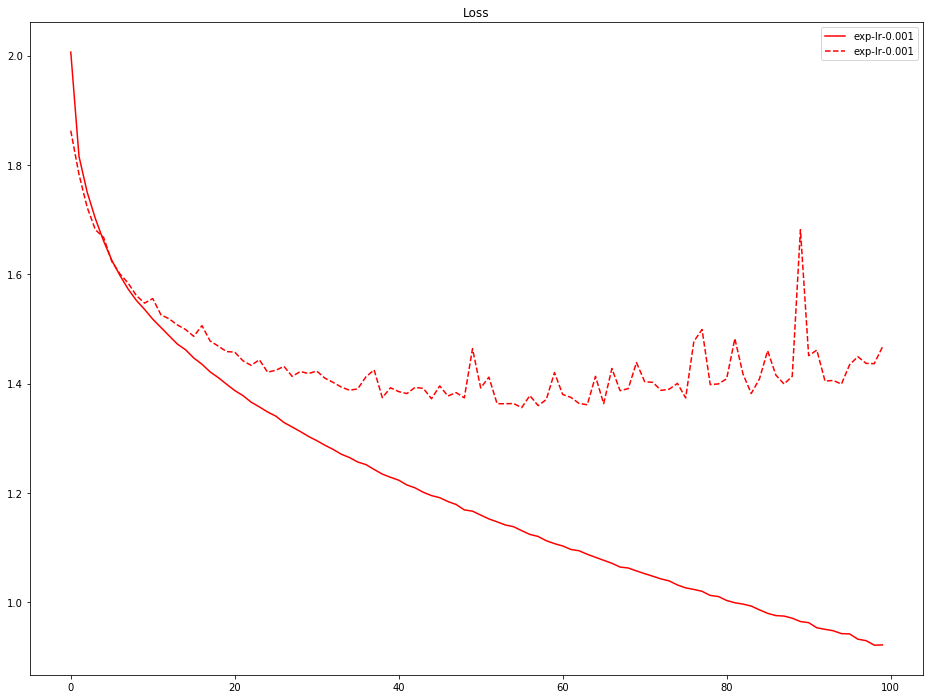

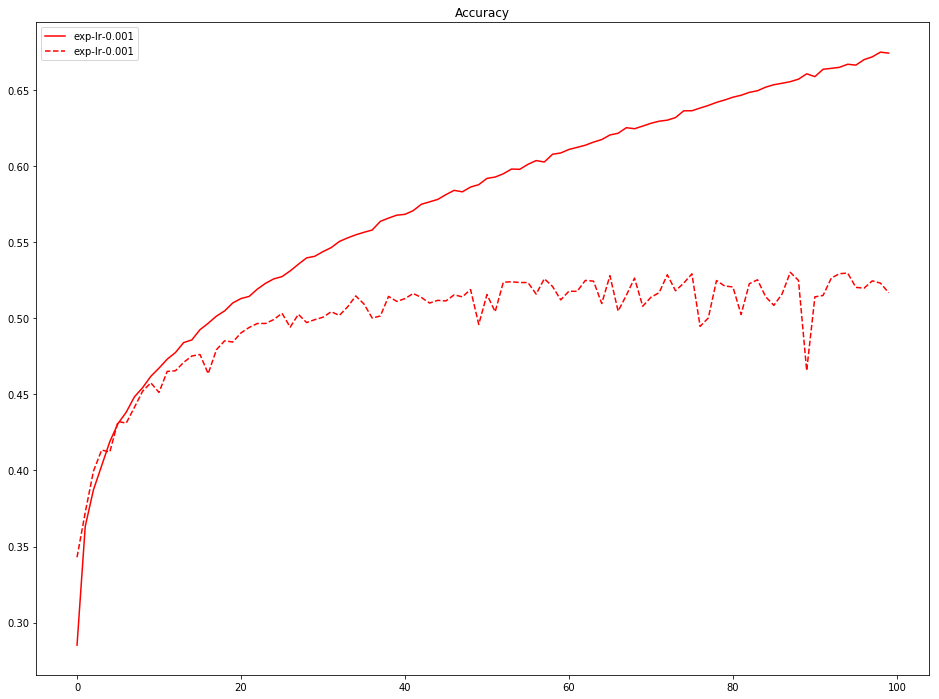

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "c", "w"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()